<a href="https://colab.research.google.com/github/invigoro/ArtificialFrameGenerator/blob/main/CVProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

  if event.key is 'enter':



Mounted at /content/drive


In [ ]:
%cd drive/Shareddrives/CVProject/Colab

/content/drive/Shareddrives/CVProject/Colab


In [ ]:
import random
# Read the image
image = cv2.imread('car.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150)

# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour
#largest_contour = random.choice(contours)
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the selected region
mask = np.zeros_like(gray)
cv2.drawContours(mask, [largest_contour], 0, 255, -1)

# Extract the region of interest
roi = cv2.bitwise_and(image, image, mask=mask)

# Display the results
cv2_imshow(image)
cv2_imshow(edges)
cv2_imshow(roi)

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


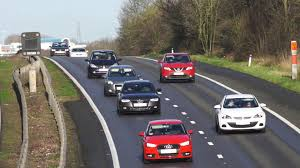

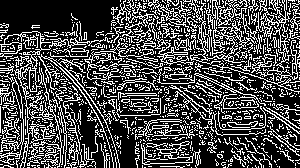

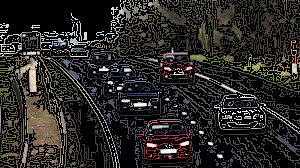

In [ ]:
# Read the image
image = cv2.imread('car.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection

edges = cv2.Canny(gray, 100, 200)

# Find contours
contours, hierarchy = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the regions of interest
mask = np.zeros_like(image)

# Draw the contours on the mask
cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)

# Extract the regions of interest
result = cv2.bitwise_and(image, mask)

# Display the results
cv2_imshow(image)
cv2_imshow(edges)
cv2_imshow(result)

# Frame Generation Code

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from time import time


def detect_edges_and_contours(frame, closing_kernel_size=10):
    """Detect edges, close gaps using morphological operations, and return contours."""
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_frame, 50, 100)

    # Define a kernel for closing gaps
    kernel = np.ones((closing_kernel_size, closing_kernel_size), np.uint8)
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    # Detect contours on the closed edges
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def calculate_optical_flow(prev_frame, next_frame, scale_factor=0.5):
    """Calculate the optical flow from prev_frame to next_frame using Farneback method, with optional scaling."""
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Resize frames to reduce calculation time
    prev_small = cv2.resize(prev_gray, None, fx=scale_factor, fy=scale_factor)
    next_small = cv2.resize(next_gray, None, fx=scale_factor, fy=scale_factor)

    # Calculate optical flow at a smaller resolution (prev to next)
    flow = cv2.calcOpticalFlowFarneback(prev_small, next_small, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)

    # Scale flow back to the original resolution
    flow = cv2.resize(flow, (prev_gray.shape[1], prev_gray.shape[0]))
    flow[..., 0] *= (1 / scale_factor)
    flow[..., 1] *= (1 / scale_factor)

    # Invert flow direction to move from prev_frame toward next_frame
    flow = -flow

    return flow

def apply_motion_blur(frame, flow, ratio):
    """Apply motion blur to the frame based on the optical flow."""
    # Calculate average flow direction and magnitude
    dx = flow[..., 0].mean() * ratio
    dy = flow[..., 1].mean() * ratio
    magnitude = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    # Create a linear motion blur kernel
    size = max(5, int(magnitude))  # Kernel size proportional to motion magnitude
    kernel = np.zeros((size, size), dtype=np.float32)
    x_center, y_center = size // 2, size // 2

    # Define the motion direction
    x_end = int(x_center + np.cos(angle) * (size - 1))
    y_end = int(y_center + np.sin(angle) * (size - 1))
    cv2.line(kernel, (x_center, y_center), (x_end, y_end), 1, thickness=1)

    # Normalize the kernel
    kernel /= kernel.sum()

    # Apply the kernel as a filter
    return cv2.filter2D(frame, -1, kernel)

def generate_interpolated_frames(frame, flow, contours, num_generated=5):
    """Generate intermediate frames by applying incremental flow across the entire frame."""
    h, w = frame.shape[:2]
    interpolated_frames = []
    step_factor = 1 / (num_generated + 1)

    # Generate base mapping coordinates for the frame
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h), indexing='xy')

    for j in range(1, num_generated + 1):
        # Fractional displacement for the current interpolation step
        ratio = j * step_factor
        dx_interp, dy_interp = flow[..., 0] * ratio, flow[..., 1] * ratio

        # Calculate the interpolated maps for the entire frame
        interp_map_x = (map_x + dx_interp).astype(np.float32)
        interp_map_y = (map_y + dy_interp).astype(np.float32)

        # Remap the entire frame according to the interpolated flow maps
        moved_frame = cv2.remap(frame, interp_map_x, interp_map_y, interpolation=cv2.INTER_LINEAR)

        # Mask out only the areas corresponding to contours to reduce tearing artifacts
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
        interpolated_frame = np.where(mask[..., None] > 0, moved_frame, frame)

        blurred_frame = apply_motion_blur(interpolated_frame, flow, ratio)
        interpolated_frames.append(blurred_frame)

    return interpolated_frames

def process_video_frames(input_path, output_path, num_generated=5, scale_factor=0.5):
    # Keep track of run time
    start_time = int(time() * 1000) # in milliseconds

    """Process a video file, generate new frames with artificial motion, and save it with higher frame rate."""
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get original video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    # Set new frame rate to include interpolated frames
    new_fps = fps * (1 + num_generated)

    # Video writer to save output with higher frame rate
    out = cv2.VideoWriter(output_path, fourcc, new_fps, (width, height))

    # Initialize progress bar
    progress_bar = tqdm(total=total_frames - 1, desc="Processing frames", unit="frame")

    # Read the first frame
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    # Add padding for the first frame
    #for _ in range(num_generated):
        #out.write(prev_frame)

    while True:
        # Read the next frame
        ret, next_frame = cap.read()
        if not ret:
            break

        # Calculate optical flow between frames with downscaling
        flow = calculate_optical_flow(prev_frame, next_frame, scale_factor)

        # Detect contours with morphological closing to fill gaps in the edges
        contours = detect_edges_and_contours(prev_frame)

        # Generate and write interpolated frames
        interpolated_frames = generate_interpolated_frames(prev_frame, flow, contours, num_generated)
        for interpolated_frame in interpolated_frames:
            out.write(interpolated_frame)

        # Write the original next_frame to maintain video continuity
        out.write(next_frame)

        # Update progress bar
        progress_bar.update(1)

        # Set next_frame as prev_frame for the next iteration
        prev_frame = next_frame

    # Add padding for the last frame
    for _ in range(num_generated):
        out.write(prev_frame)

    # Release resources
    cap.release()
    out.release()
    progress_bar.close()
    end_time = int(time() * 1000) # in milliseconds
    elapsed_millis = (end_time - start_time)
    print("Video processing completed in " + str(elapsed_millis / 1000) + " seconds. Saved to ", output_path)

    # Print video properties for records
    print("Res: " + str(width) + "x" + str(height))
    print("FPS: " + str(fps) + "-->" + str(new_fps))
    print("Duration: " + str(int(total_frames / fps)) + " sec")

# Usage
# process_video_frames("AC_Origins_CV_15fps.mp4", "output_videoACOrigins.mp4", num_generated=1, scale_factor=0.8)

In [ ]:
# Execute the frame generation here
video_names = ["SW_Battlefront_II_reduced.mp4"]

video_input_path = "Video/Reduced/"
video_output_path = "Video/Output/"

for v in video_names:
  pieces = v.split('.')
  filename = pieces[0]
  extension = pieces[1]
  output_name = filename.replace("_reduced", "") + "_generated." + extension
  print("Writing " + v + " to " + output_name + ".")
  process_video_frames(video_input_path + v, video_output_path + output_name, 1)

Writing cars_superreduced.mp4 to cars_supergenerated.mp4.


Processing frames: 100%|██████████| 300/300 [03:32<00:00,  1.42frame/s]

Video processing completed in 213.777 seconds. Saved to  Video/Output/cars_supergenerated.mp4
Res: 1920x1080
FPS: 5.0-->25.0
Duration: 60 sec


In [ ]:
def apply_motion_blur(frame, blur_strength=5):
    """
    Applies a subtle motion blur to a frame.
    :param frame: Input frame (numpy array).
    :param blur_strength: Determines the blur strength; higher values increase blur.
    :return: Motion-blurred frame.
    """
    # Create the kernel for motion blur
    kernel = np.zeros((blur_strength, blur_strength))
    kernel[int((blur_strength - 1) / 2), :] = np.ones(blur_strength)
    kernel /= blur_strength

    # Apply the motion blur kernel to the frame
    blurred_frame = cv2.filter2D(frame, -1, kernel)
    return blurred_frame

def process_video_blur(input_video_path, output_video_path, blur_strength=5):
    """
    Reads an input video, applies a motion blur to each frame, and saves the result.
    :param input_video_path: Path to the input video file.
    :param output_video_path: Path to save the output blurred video file.
    :param blur_strength: Motion blur strength for each frame.
    """
    # Load video using MoviePy
    clip = VideoFileClip(input_video_path)

    # Process each frame in the video
    blurred_clip = clip.fl_image(lambda frame: apply_motion_blur(frame, blur_strength))

    # Write the result to a new video file
    blurred_clip.write_videofile(output_video_path, codec="libx264", audio_codec="aac")

# Example usage:
process_video_blur("output_videoglider.mp4", "output_blurred_video.mp4", blur_strength=2)

OSError: MoviePy error: the file output_videoglider.mp4 could not be found!
Please check that you entered the correct path.

# Video Comparison Creation Code

In [ ]:
import cv2
from tqdm import tqdm

def create_side_by_side_comparison(original_path, processed_path, output_path, num_generated=5):
    """Create a side-by-side comparison video showing the original and processed videos with synchronized playback."""
    # Open both video files
    original_cap = cv2.VideoCapture(original_path)
    processed_cap = cv2.VideoCapture(processed_path)

    # Check if both videos are opened successfully
    if not original_cap.isOpened() or not processed_cap.isOpened():
        print("Error: Could not open one of the videos.")
        return

    # Get properties from the original video
    fps = original_cap.get(cv2.CAP_PROP_FPS)
    width = int(original_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(original_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Adjusted frame rate for the output video to maintain synchronized playback
    new_fps = fps * (1 + num_generated)

    # Video writer to save the side-by-side output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, new_fps, (width * 2, height))

    # Initialize progress bar
    progress_bar = tqdm(total=total_frames, desc="Creating side-by-side video", unit="frame")

    while True:
        # Read a single frame from the original video
        ret1, original_frame = original_cap.read()
        if not ret1:
            break

        # Read `1 + num_generated` frames from the processed video
        for _ in range(1 + num_generated):
            ret2, processed_frame = processed_cap.read()
            if not ret2:
                break

            # Resize processed frame if necessary to match the original frame size
            processed_frame = cv2.resize(processed_frame, (width, height))

            # Concatenate the original frame and processed frame horizontally
            side_by_side_frame = cv2.hconcat([original_frame, processed_frame])

            # Write the concatenated frame to the output video
            out.write(side_by_side_frame)

        # Update progress bar
        progress_bar.update(1)

    # Release resources
    original_cap.release()
    processed_cap.release()
    out.release()
    progress_bar.close()
    print("Side-by-side video creation complete. Saved to", output_path)

# Usage
create_side_by_side_comparison("Video/Output/MacbethSwordFight_generated.mp4", "Video/AI_Output/MacbethSwordFight_reduced_RIFE_4.17x2_Resize-100.mp4", "comparison_sword_flowvsai.mp4", num_generated=0)

Creating side-by-side video: 100%|██████████| 1615/1615 [00:13<00:00, 122.77frame/s]


Side-by-side video creation complete. Saved to comparison_sword_flowvsai.mp4


In [ ]:
# Execute the side-by-side-comparison generation here
video_names = ["a_trip_to_the_moon.mp4",
               "near_miss.mp4",
               "walking_outdoors1.mp4",
               "walking_outdoors2.mp4",
               "great_train_robbery.mp4",
               "great_auk.mp4",
               "cars.mp4",
               "gliderlowq.mp4",
               "AC_Origins_CV.mp4",
               "MacbethSwordFight.mp4",
               "SW_Battlefront_II.mp4"]

video_original_path = "Video/Original/"
video_reduced_path = "Video/Reduced/"
video_generated_path = "Video/Output/"
video_comparison_path = "Video/Comparison/"

for v in video_names:
  pieces = v.split('.')
  filename = pieces[0]
  extension = pieces[1]
  reduced_name = filename + "_reduced." + extension
  generated_name = filename + "_generated." + extension
  comparison_name1 = filename + "_comparison_o2g." + extension
  comparison_name2 = filename + "_comparison_r2g." + extension

  # first compare original to generated
  print("Writing " + v + " and " + generated_name + " to " + comparison_name1 + ".")
  create_side_by_side_comparison(video_original_path + v,
                                 video_generated_path + generated_name,
                                 video_comparison_path + comparison_name1,
                                 num_generated=0) #set to 0 since I'm comparing the original (NOT reduced) to the generated, both of which have the same framerate


  # then compare reduced to generated
  print("Writing " + reduced_name + " and " + generated_name + " to " + comparison_name2 + ".")
  create_side_by_side_comparison(video_reduced_path + reduced_name,
                                 video_generated_path + generated_name,
                                 video_comparison_path + comparison_name2,
                                 num_generated=1)

Writing cars_superreduced.mp4 and cars_supergenerated.mp4 to cars_supercomparison_r2g.mp4.



Creating side-by-side video: 100%|██████████| 301/301 [01:14<00:00,  4.06frame/s]

Side-by-side video creation complete. Saved to Video/Comparison/cars_supercomparison_r2g.mp4
